In [1]:
# import sys
# sys.path.append('/disk1/home/yupeng/EndOfSep/FusionNet')
# print(sys.path)

# TODO 
# One way to optimize the arcitechture
# instead of adding two layer in RoIHead, made more complex structure there 

In [42]:
from model.faster_rcnn_vgg16 import FasterRCNNVGG16

In [43]:
a = FasterRCNNVGG16()

In [44]:
import torch
from collections import namedtuple
from torchnet.meter import ConfusionMeter, AverageValueMeter
from torch.nn import functional as F
from torch import nn

In [45]:
LossTuple = namedtuple('LossTuple',
                       ['rpn_loc_loss',
                        'rpn_cls_loss',
                        'roi_loc_loss',
                        'roi_cls_loss',
                        'depth_loss',
                        'y_rot_loss',
                        'total_loss'
                        ])

In [46]:
imgs = torch.zeros((1, 3, 600, 800)).float().cuda()
features = a.extractor(imgs) 

In [47]:
_, _, H, W = imgs.shape
img_size = (H, W)

features.shape

torch.Size([1, 512, 37, 50])

In [48]:
rpn_locs, rpn_scores, rois, roi_indices, anchor = \
            a.rpn(features, (600,800), 1)

In [49]:
bboxes = torch.FloatTensor([[300, 200, 600, 700]]).reshape(1,1,4)
labels = torch.Tensor([[2]]).reshape(1,1)
depths = torch.Tensor([[2]]).reshape(1,1).cuda()
y_rots = torch.Tensor([[2]]).reshape(1,1).cuda()

In [50]:
rpn_locs.shape

torch.Size([1, 16650, 4])

In [51]:
bbox = bboxes[0]
label = labels[0]
rpn_score = rpn_scores[0]
rpn_loc = rpn_locs[0]
roi = rois
depth = depths[0]
y_rot = y_rots[0]


In [52]:
# https://github.com/chenyuntc/simple-faster-rcnn-pytorch/blob/0ea7069318692d6cf80c0dcbae7ed45b70cfc5e8/trainer.py
# line 100

In [53]:
from utils import array_tool as at
from model.utils.creator_tool import AnchorTargetCreator, ProposalTargetCreator

proposal_target_creator = ProposalTargetCreator()

In [54]:
sample_roi, gt_roi_loc, gt_roi_label = proposal_target_creator(roi, at.tonumpy(bbox), at.tonumpy(label))

In [55]:
gt_roi_label

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [17]:
sample_roi_index = torch.zeros(len(sample_roi))
# sample_roi_index = sample_roi_index.cuda()

In [18]:
roi_cls_loc, roi_score, roi_depth, roi_y_rot = a.head(features,
                                sample_roi,
                                sample_roi_index)

/opt/conda/conda-bld/pytorch_1565272279342/work/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [17]:
roi_depth.shape

torch.Size([128, 1])

In [18]:
roi_y_rot.shape

torch.Size([128, 1])

In [19]:
roi_score.shape

torch.Size([128, 4])

In [20]:
roi_cls_loc.shape

torch.Size([128, 16])

In [19]:
rpn_cm = ConfusionMeter(2)
roi_cm = ConfusionMeter(4)
meters = {k: AverageValueMeter() for k in LossTuple._fields}  # average loss

In [20]:
def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    in_weight = torch.zeros(gt_loc.shape).cuda()
    # Localization loss is calculated only for positive rois.
    # NOTE:  unlike origin implementation, 
    # we don't need inside_weight and outside_weight, they can calculate by gt_label
    in_weight[(gt_label > 0).view(-1, 1).expand_as(in_weight).cuda()] = 1
    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, in_weight.detach(), sigma)
    # Normalize by total number of negtive and positive rois.
    loc_loss /= ((gt_label >= 0).sum().float()) # ignore gt_label==-1 for rpn_loss
    return loc_loss

def _smooth_l1_loss(x, t, in_weight, sigma):
    sigma2 = sigma ** 2
    diff = in_weight * (x - t)
    abs_diff = diff.abs()
    flag = (abs_diff.data < (1. / sigma2)).float()
    y = (flag * (sigma2 / 2.) * (diff ** 2) +
         (1 - flag) * (abs_diff - 0.5 / sigma2))
    return y.sum()

In [38]:
anchor_target_creator = AnchorTargetCreator()
rpn_sigma = 3
roi_sigma = 1

gt_rpn_loc, gt_rpn_label = anchor_target_creator(at.tonumpy(bbox),
                                                 anchor,
                                                 img_size)
gt_rpn_label = at.totensor(gt_rpn_label).long()
gt_rpn_loc = at.totensor(gt_rpn_loc)
rpn_loc_loss = _fast_rcnn_loc_loss(rpn_loc,
                                   gt_rpn_loc,
                                   gt_rpn_label.data,
                                   rpn_sigma)

# NOTE: default value of ignore_index is -100 ...
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label.cuda(), ignore_index=-1)
_gt_rpn_label = gt_rpn_label[gt_rpn_label > -1]
_rpn_score = at.tonumpy(rpn_score)[at.tonumpy(gt_rpn_label) > -1]
# rpn_cm.add(at.totensor(_rpn_score, False), _gt_rpn_label.data.long())

# ------------------ ROI losses (fast rcnn loss) -------------------#
n_sample = roi_cls_loc.shape[0]
roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
roi_loc = roi_cls_loc[torch.arange(0, n_sample).long().cuda(), \
                      at.totensor(gt_roi_label).long()]


gt_roi_label = at.totensor(gt_roi_label).long()

gt_roi_loc = at.totensor(gt_roi_loc)

roi_loc_loss = _fast_rcnn_loc_loss(
    roi_loc.contiguous(),
    gt_roi_loc,
    gt_roi_label.data,
    roi_sigma)

roi_cls_loss = nn.CrossEntropyLoss()(roi_score, gt_roi_label.cuda())

roi_cm.add(at.totensor(roi_score, False), gt_roi_label.data.long())


depth_loss = torch.nn.L1Loss()(roi_depth, depth)
y_rot_loss = torch.nn.L1Loss()(roi_y_rot.cos(), y_rot.cos())

losses = [rpn_loc_loss, rpn_cls_loss, roi_loc_loss, roi_cls_loss, depth_loss, y_rot_loss]
losses = losses + [sum(losses)]


<class 'numpy.ndarray'>


In [39]:
type(gt_roi_label)

torch.Tensor

In [22]:
losses = LossTuple(*losses)

In [23]:
optimizer = a.get_optimizer()
optimizer.zero_grad()
losses.total_loss.backward()
optimizer.step()

In [24]:
roi_cm.add(at.totensor(roi_score, False), gt_roi_label.data.long())

In [27]:
roi_cm

In [28]:
losses

LossTuple(rpn_loc_loss=tensor(0.0025, device='cuda:0', grad_fn=<DivBackward0>), rpn_cls_loss=tensor(0.6938, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(0.2481, device='cuda:0', grad_fn=<DivBackward0>), roi_cls_loss=tensor(1.3723, device='cuda:0', grad_fn=<NllLossBackward>), depth_loss=tensor(1.9550, device='cuda:0', grad_fn=<L1LossBackward>), y_rot_loss=tensor(1.4159, device='cuda:0', grad_fn=<L1LossBackward>), total_loss=tensor(5.6876, device='cuda:0', grad_fn=<AddBackward0>))

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
f_img   = '/disk1/home/yupeng/Data/K3OD/training/image_2/000115.png'
img = mpimg.imread(f_img) 

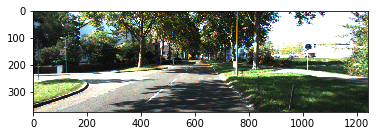

In [30]:
img = mpimg.imread(f_img) 
plt.imshow(img)

In [31]:
img.shape

(375, 1242, 3)